Dataset Columns: Index(['PATIENT_ID', 'DATE', 'DURATION', 'PERDAY', 'CATEGORY', 'CATEGORY_L1',
       'CATEGORY_L2'],
      dtype='object')


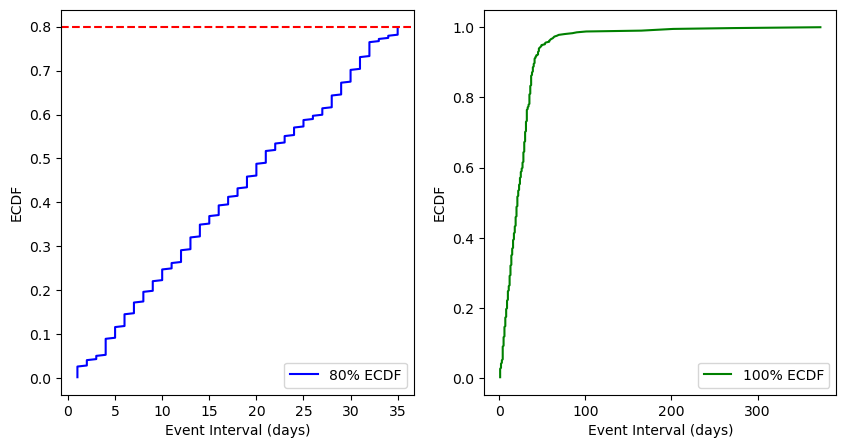

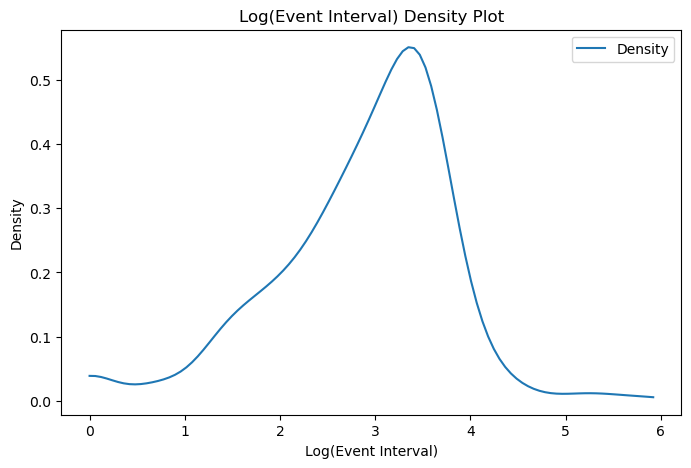

D:\Users\fbasi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Users\fbasi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Users\fbasi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Users\fbasi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

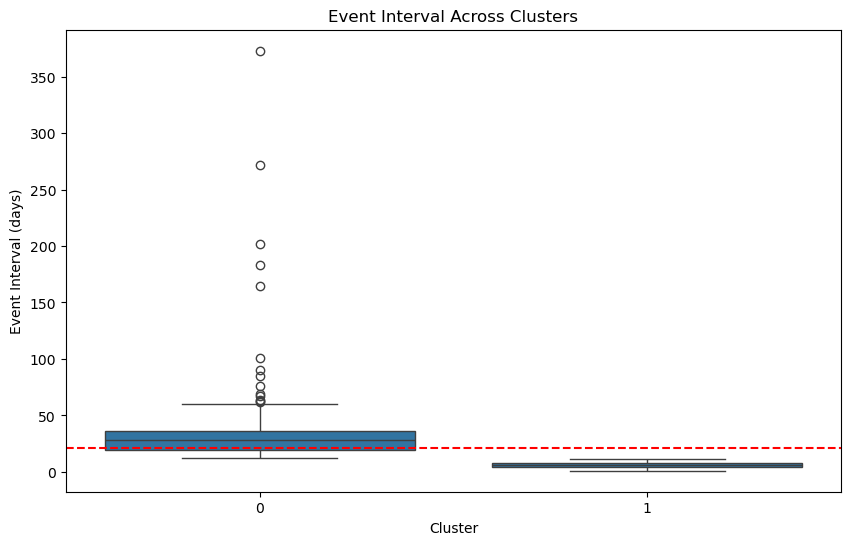

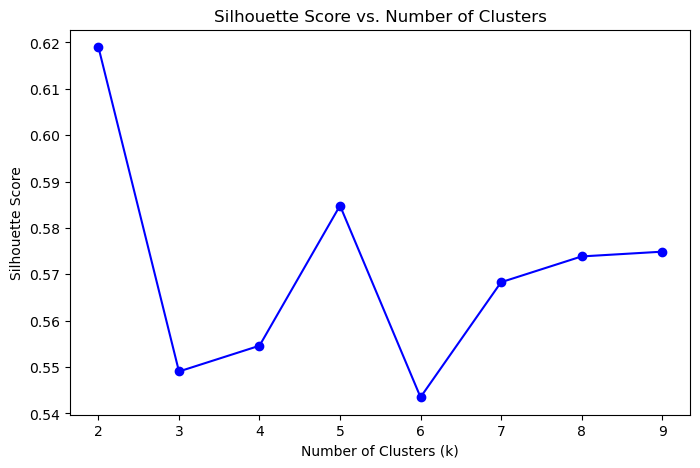

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter("always")


# Load the dataset (update with actual file path)
data = pd.read_csv('med_events.csv')

# Check column names
print("Dataset Columns:", data.columns)

# Rename columns if necessary
data.rename(columns={'DATE': 'eksd', 'PATIENT_ID': 'pnr'}, inplace=True)

# Data Preprocessing
data['eksd'] = pd.to_datetime(data['eksd'])
data = data.sort_values(by=['pnr', 'eksd'])
data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
data = data.dropna()
data['event_interval'] = (data['eksd'] - data['prev_eksd']).dt.days
data = data[data['event_interval'] > 0]  # Ensure no zero or negative intervals

# ECDF Calculation
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x, y = ecdf(data['event_interval'])
df_ecdf = pd.DataFrame({'x': x, 'y': y})
df_ecdf = df_ecdf[df_ecdf['y'] <= 0.8]

# Plot ECDF
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df_ecdf['x'], df_ecdf['y'], label='80% ECDF', color='blue')
plt.axhline(y=0.8, linestyle='dashed', color='red')
plt.xlabel("Event Interval (days)")
plt.ylabel("ECDF")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, y, label='100% ECDF', color='green')
plt.xlabel("Event Interval (days)")
plt.ylabel("ECDF")
plt.legend()
plt.show()

# Density Plot
density = gaussian_kde(np.log(data['event_interval']))
x_vals = np.linspace(min(np.log(data['event_interval'])), max(np.log(data['event_interval'])), 100)
y_vals = density(x_vals)
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label="Density")
plt.title("Log(Event Interval) Density Plot")
plt.xlabel("Log(Event Interval)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Finding Optimal Clusters
scaled_data = np.log(data[['event_interval']])
sil_scores = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    sil_scores[k] = score

optimal_k = max(sil_scores, key=sil_scores.get)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(scaled_data)
data['cluster'] = kmeans.labels_

# Cluster Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['cluster'], y=data['event_interval'])
plt.axhline(y=np.median(data['event_interval']), color='red', linestyle='dashed')
plt.xlabel("Cluster")
plt.ylabel("Event Interval (days)")
plt.title('Event Interval Across Clusters')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.show()

